In [1]:
import kaggle

In [2]:
!/home/gguser01/.venvs/vfastai/bin/kaggle competitions download -c digit-recognizer

digit-recognizer.zip: Skipping, found more recently modified local copy (use --force to force download)


In [363]:
import zipfile, torch, math, os, PIL, torchvision

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [151]:
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu'); device

device(type='cpu')

In [4]:
zf = zipfile.ZipFile('digit-recognizer.zip'); zf.filelist

In [152]:
train_df = pd.read_csv(zf.open('train.csv'), dtype='float32')
test_df = pd.read_csv(zf.open('test.csv'), dtype='float32')

In [153]:
train_df.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [469]:
class mnist_dataset(torch.utils.data.Dataset):
    
    def __init__(self, data, transform=None, linear=True, test=False):
        self.data = data
        self.transform = transform
        self.linear = linear
        self.test = test
        
    def __len__(self):
        return self.data.shape[0]
    
    def __getitem__(self, idx):
        
        if not self.test:
            img = self.data.iloc[idx].iloc[1:].div(255).to_numpy()
            lbl = train_df.iloc[idx].label
        else:
            img = self.data.iloc[idx].div(255).to_numpy()
            lbl = np.empty(0)
        
        if not self.linear: img = img.reshape(1, 28, 28)
            
        if self.transform: img = self.transform(img.reshape(28, 28, 1))

        return img, lbl

In [239]:
#https://discuss.pytorch.org/t/whats-the-difference-between-torch-reshape-vs-torch-view/159172
#reshape will return a view if possible and will trigger a copy otherwise as explained in the docs 108. If in doubt, you can use reshape if you do not explicitly expect a view of the tensor.
#A view points to the same data stored in memory using a changed meta-data such as its shape and stride.
x = torch.randn(2, 4); print('x', x.size(), x.stride(), x.is_contiguous())
y = x.view(-1); print('y', y.size(), y.stride(), y.is_contiguous())

w = torch.randn(2, 4, 8); print('w', w.size(), w.stride(), w.is_contiguous())
z = w[:, ::2]; print('z', z.size(), z.stride(), z.is_contiguous())
#z1 = z.view(-1) RuntimeError: view size is not compatible with input tensor's size...
z2 = z.reshape(-1); print('z2', z2.size(), z2.stride(), z2.is_contiguous())

x torch.Size([2, 4]) (4, 1) True
y torch.Size([8]) (1,) True
w torch.Size([2, 4, 8]) (32, 8, 1) True
z torch.Size([2, 2, 8]) (32, 16, 1) False
z2 torch.Size([32]) (1,) True


In [328]:
torch.from_numpy(train_df.iloc[0].iloc[1:].div(255).values).view(1, 28, 28)

tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,

In [329]:
mnist_ds = mnist_dataset(train_df); len(train_data)

In [168]:
batch_size = 64
validation_split = .2
shuffle_dataset = True
random_seed = 42

generator = torch.Generator().manual_seed(random_seed)

validation_size = int(len(mnist_ds) * validation_split)
train_size = len(mnist_ds) - validation_size

train_dataset, validation_dataset = torch.utils.data.random_split(
    mnist_ds,
    [train_size, validation_size],
    generator=generator
)

train_dataloader = torch.utils.data.DataLoader(
    train_dataset, 
    batch_size=batch_size, 
    shuffle=shuffle_dataset
)
validation_dataloader = torch.utils.data.DataLoader(
    validation_dataset,
    batch_size=batch_size,
    shuffle=shuffle_dataset
)

In [169]:
print(len(train_dataset), len(validation_dataset))

33600 8400


In [170]:
train_features, train_labels = next(iter(train_dataloader))
val_features, val_labels = next(iter(validation_dataloader))

print(f'Feature batch shape: {train_features.size()}')
print(f'Labels batch shape: {train_labels.size()}')
print(f'Data in the batch: {train_features}')

Feature batch shape: torch.Size([64, 784])
Labels batch shape: torch.Size([64])
Data in the batch: tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


tensor(7.)

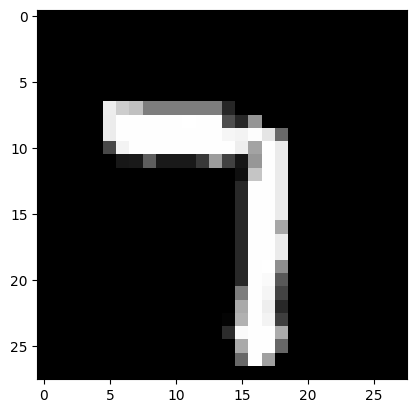

In [330]:
plt.imshow(train_features[idx].reshape(28, 28, 1), cmap='gray'); train_labels[idx]

tensor(8.)

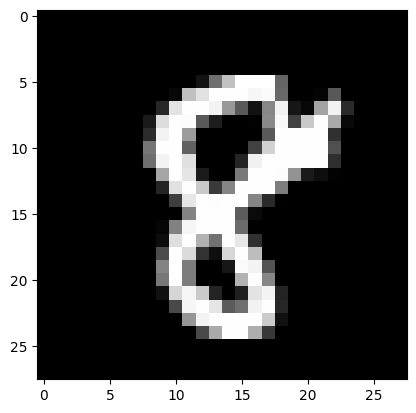

In [331]:
plt.imshow(val_features[idx].reshape(28, 28, 1), cmap='gray'); val_labels[idx]

In [187]:
def train_model(model, train_loader, val_loader, loss, optimizer, num_epochs):
    
    #import ipdb; ipdb.set_trace()
    
    for epoch in range(num_epochs):
        
        model.train()

        loss_accum = 0
        correct_samples = 0
        total_samples = 0

        for i_step, (x, y) in enumerate(train_loader):
            
            x = x.to(device)
            y = y.long().to(device)
            
            prediction = model(x)
            loss_value = loss(prediction, y)
            
            loss_value.backward()
            optimizer.step()
            optimizer.zero_grad()
            
            _, indices = torch.max(prediction, 1)
            correct_samples += torch.sum(indices == y)
            total_samples += y.shape[0]

            loss_accum += loss_value

        ave_loss = loss_accum / i_step
        train_acc = float(correct_samples) / total_samples
        val_acc = compute_accuracy(model, val_loader)

        print("Epoch: %i/%i, Average Loss: %f, Train acc: %f, Val acc: %f" %
            (epoch + 1, num_epochs, ave_loss, train_acc, val_acc)
        )

In [188]:
def compute_accuracy(model, loader):

    model.eval()
    
    correct_samples, total_samples = 0, 0

    with torch.no_grad():

        for i, (inputs, labels) in enumerate(loader):
            x = inputs.to(device)
            y = labels.to(device)

            output = model(x)
            prediction = torch.argmax(output, axis=1)
        
            correct_samples += torch.sum(prediction == y)
            total_samples += y.shape[0]

    return correct_samples / total_samples

In [ ]:
#linear

In [207]:
model_0 = torch.nn.Linear(28 * 28, 10)
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_0.parameters(), lr=.5)

In [208]:
train_model(model_0, train_dataloader, validation_dataloader, loss, optimizer, 10)

Epoch: 1/10, Average Loss: 0.408749, Train acc: 0.882381, Val acc: 0.906548
Epoch: 2/10, Average Loss: 0.308169, Train acc: 0.911190, Val acc: 0.910119
Epoch: 3/10, Average Loss: 0.290119, Train acc: 0.916964, Val acc: 0.911310
Epoch: 4/10, Average Loss: 0.280228, Train acc: 0.920298, Val acc: 0.909405
Epoch: 5/10, Average Loss: 0.272925, Train acc: 0.922589, Val acc: 0.912738
Epoch: 6/10, Average Loss: 0.267821, Train acc: 0.923661, Val acc: 0.913333
Epoch: 7/10, Average Loss: 0.263928, Train acc: 0.924345, Val acc: 0.915238
Epoch: 8/10, Average Loss: 0.259738, Train acc: 0.925685, Val acc: 0.912976
Epoch: 9/10, Average Loss: 0.256323, Train acc: 0.925923, Val acc: 0.909286
Epoch: 10/10, Average Loss: 0.253960, Train acc: 0.927381, Val acc: 0.914048


In [277]:
#convs

In [415]:
mnist_ds_conv = mnist_dataset(
    train_df, 
    linear=False, 
    transform=torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
        torchvision.transforms.RandomRotation(
            10, interpolation=torchvision.transforms.InterpolationMode.BILINEAR
        ),
    ])
)

In [416]:
batch_size = 64
validation_split = .2
shuffle_dataset = True
random_seed = 42

generator = torch.Generator().manual_seed(random_seed)

validation_size = int(len(mnist_ds_conv) * validation_split)
train_size = len(mnist_ds_conv) - validation_size

train_dataset_conv, validation_dataset_conv = torch.utils.data.random_split(
    mnist_ds_conv,
    [train_size, validation_size],
    generator=generator
)

train_dataloader_conv = torch.utils.data.DataLoader(
    train_dataset_conv, 
    batch_size=batch_size, 
    shuffle=shuffle_dataset
)
validation_dataloader_conv = torch.utils.data.DataLoader(
    validation_dataset_conv,
    batch_size=batch_size,
    shuffle=shuffle_dataset
)

In [417]:
next(iter(train_dataloader_conv))[0].size()

torch.Size([64, 1, 28, 28])

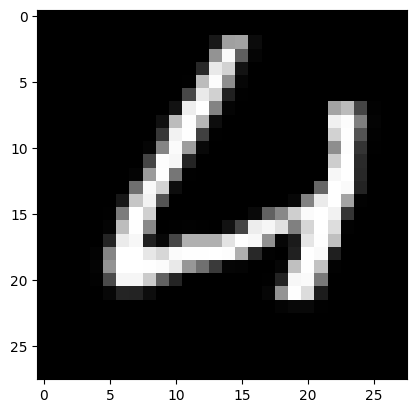

In [428]:
plt.imshow(next(iter(train_dataloader_conv))[0][0].reshape(28, 28, 1), cmap='gray')

In [429]:
#lenet

lr = 1e-1
wd = 1e-5

model_lenet = torch.nn.Sequential(
    torch.nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, padding=0),
    torch.nn.Tanh(),
    torch.nn.AvgPool2d(2),
    torch.nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, padding=0),
    torch.nn.Tanh(),
    torch.nn.AvgPool2d(2),

    torch.nn.Flatten(),

    torch.nn.Linear(256, 140),
    torch.nn.Tanh(),
    torch.nn.Linear(140, 84),
    torch.nn.Tanh(),
    torch.nn.Linear(84, 10)
)

loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_lenet.parameters(), lr=lr, weight_decay=wd)

In [493]:
train_model(model_lenet, train_dataloader_conv, validation_dataloader_conv, loss, optimizer, 10)

Epoch: 1/10, Average Loss: 0.002654, Train acc: 0.999494, Val acc: 0.987024
Epoch: 2/10, Average Loss: 0.003087, Train acc: 0.999435, Val acc: 0.985714
Epoch: 3/10, Average Loss: 0.002468, Train acc: 0.999702, Val acc: 0.986786
Epoch: 4/10, Average Loss: 0.002469, Train acc: 0.999643, Val acc: 0.986310
Epoch: 5/10, Average Loss: 0.002419, Train acc: 0.999583, Val acc: 0.986786
Epoch: 6/10, Average Loss: 0.002902, Train acc: 0.999345, Val acc: 0.987262
Epoch: 7/10, Average Loss: 0.002213, Train acc: 0.999673, Val acc: 0.987024
Epoch: 8/10, Average Loss: 0.002221, Train acc: 0.999732, Val acc: 0.987024
Epoch: 9/10, Average Loss: 0.002886, Train acc: 0.999375, Val acc: 0.986429
Epoch: 10/10, Average Loss: 0.002537, Train acc: 0.999464, Val acc: 0.986786


In [481]:
test_dataset = mnist_dataset(test_df, linear=False, test=True)
test_dataload = torch.utils.data.DataLoader(
    test_dataset, batch_size=len(test_dataset)
)

In [494]:
test_res = model_lenet(test_img).argmax(dim=1)

In [485]:
len(test_res)

28000

In [495]:
pd.DataFrame(
    {
        'ImageId':range(1, len(test_res)+1),
        'Label': test_res
    }
).to_csv('submission_131223_Lenet_0.csv', sep=',', index=False)

In [496]:
torch.save(model_lenet, '1_lenet_0986786.pt')

In [499]:
#capsule_network
#https://github.com/gram-ai/capsule-networks/

BATCH_SIZE = 100
NUM_CLASSES = 10
NUM_EPOCHS = 500
NUM_ROUTING_ITERATIONS = 3

In [533]:
def softmax(input, dim=1):
    transposed_input = input.transpose(dim, len(input.size()) - 1)
    softmaxed_output = torch.functional.softmax(transposed_input.contiguous().view(-1, transposed_input.size(-1)), dim=-1)
    return softmaxed_output.view(*transposed_input.size()).transpose(dim, len(input.size()) - 1)
    
class CapsuleLayer(torch.nn.Module):
    def __init__(self, num_capsules, num_route_nodes, in_channels, out_channels,
                 kernel_size=None, stride=None, num_iterations=NUM_ROUTING_ITERATIONS):
        super(CapsuleLayer, self).__init__()

        self.num_route_nodes = num_route_nodes
        self.num_iterations = num_iterations
        self.num_capsules = num_capsules

        if num_route_nodes != -1:
            self.route_weights = torch.nn.Parameter(
                torch.randn(num_capsules, num_route_nodes, in_channels, out_channels)
            )
        else:
            self.capsules = torch.nn.ModuleList(
                [torch.nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size,stride=stride, padding=0) for _ in range(num_capsules)])
    
    def squash(self, tensor, dim=-1):
        squared_norm = (tensor ** 2).sum(dim=dim, keepdim=True)
        scale = squared_norm / (1 + squared_norm)
        return scale * tensor / torch.sqrt(squared_norm)

    def forward(self, x):
        if self.num_route_nodes != -1:
            priors = x[None, :, :, None, :] @ self.route_weights[:, None, :, :, :]

            logits = torch.autograd.Variable(torch.zeros(*priors.size()))    #.cuda()
            for i in range(self.num_iterations):
                probs = softmax(logits, dim=2)
                outputs = self.squash((probs * priors).sum(dim=2, keepdim=True))

                if i != self.num_iterations - 1:
                    delta_logits = (priors * outputs).sum(dim=-1, keepdim=True)
                    logits = logits + delta_logits
        else:
            ouputs = [capsule(x).view(x.size(0), -1, 1) for capsule in self.capsules]
            outputs = torch.cat(outputs, dim=-1)
            outputs = self.squash(outputs)
        return outputs

class CapsuleNet(torch.nn.Module):
    def __init__(self):
        super(CapsuleNet, self).__init__()

        self.conv1 = torch.nn.Conv2d(in_channels=1, out_channels=256, kernel_size=9, stride=1)
        self.primary_capsules = CapsuleLayer(num_capsules=8, num_route_nodes=-1, in_channels=256, out_channels=32, kernel_size=9, stride=2)
        self.digit_capsules = CapsuleLayer(num_capsules=NUM_CLASSES, num_route_nodes=32*6*6, in_channels=8, out_channels=16)

        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(16 * NUM_CLASSES, 512),
            torch.nn.ReLU(inplace=True),
            torch.nn.Linear(512, 1024),
            torch.nn.ReLU(inplace=True),
            torch.nn.Linear(1024, 784),
            torch.nn.Sigmoid()
        )
    
    def forward(self, x, y=None):
        x = self.conv1(x)
        x = torch.nn.functional.relu(x, inplace=True)
        x = self.primary_capsules(x)
        x = self.digit_capsules(x).squeeze().transpose(0, 1)

        classes = (x ** 2).sum(dim=-1) ** 0.5
        classes = torch.nn.functional.softmax(classes, dim=-1)

        if y is None:
            # In all batches, get the most active capsule
            _, max_length_indices = classes.max(dim=1)
            y = torch.autograd.Variable(torch.eye(NUM_CLASSES)).index_select(dim=0, index=max_length_indices.data)
            #y = torch.autograd.Variable(torch.eye(NUM_CLASSES)).cuda().index_select(dim=0, index=max_length_indices.data)

        reconstructions = self.decoder((x * y[:, :, None]).view(x.size(0), -1))

        return classes, reconstructions

class CapsuleLoss(torch.nn.Module):
    def __init__(self):
        super(CapsuleLoss, self).__init__()
        self.reconstruction_loss = torch.nn.MSELoss(size_average=False)

    def forward(self, images, labels, classes, reconstructions):
        left = torch.nn.functional.relu(0.9 - classes, inplace=True) ** 2
        right = torch.nn.functional.relu(classes - 0.1, inplace=True) ** 2

        margin_loss = labels * left + 0.5 * (1. - labels) * right
        margin_loss = margin_loss.sum()

        assert torch.numel(images) == torch.numel(reconstructions)
        images = images.view(reconstructions.size()[0], -1)
        reconstruction_loss = self.reconstruction_loss(reconstructions, images)

        return (margin_loss + 0.0005 * reconstruction_loss) / images.size(0)

In [501]:
conv1 = torch.nn.Conv2d(in_channels=1, out_channels=256, kernel_size=9, stride=1)

In [525]:
step_1 = conv1(train_features[idx].view(1, 28, 28))    #.shape: torch.Size([256, 20, 20])
step_2 = torch.nn.functional.relu(step_1)
step_3 = CapsuleLayer(num_capsules=8, num_route_nodes=-1, in_channels=256, out_channels=32,
                      kernel_size=9, stride=2)
step_4 = CapsuleLayer(num_capsules=NUM_CLASSES, num_route_nodes=32*6*6, in_channels=8, out_channels=16)

In [534]:
model_capsule = CapsuleNet()
model_capsule.to(device)

optimizer = torch.optim.Adam(model.parameters())